In [16]:
# data
from mlforecast.utils import generate_daily_series

# model
from sklearn.linear_model import LinearRegression

# forecast
from mlforecast import MLForecast

# shap
import shap

# callbacks
from mlforecast.callbacks import SaveFeatures

# data

In [2]:
series = generate_daily_series(10)
print(series.head())
print()
print(series.shape)
print()
print(series["unique_id"].value_counts())

  unique_id         ds         y
0      id_0 2000-01-01  0.322947
1      id_0 2000-01-02  1.218794
2      id_0 2000-01-03  2.445887
3      id_0 2000-01-04  3.481831
4      id_0 2000-01-05  4.191721

(2376, 3)

unique_id
id_7    409
id_4    373
id_5    301
id_9    261
id_6    245
id_3    242
id_0    222
id_2    167
id_1     97
id_8     59
Name: count, dtype: int64


# training

In [5]:
fcst = MLForecast(
    models = {"lr": LinearRegression()},
    freq = "D",
    lags = [1],
    date_features = ["dayofweek"],
)
fcst.fit(series)

MLForecast(models=[lr], freq=D, lag_features=['lag1'], date_features=['dayofweek'], num_threads=1)

# model attribute

In [6]:
fcst.models_

{'lr': LinearRegression()}

In [7]:
fcst.models_["lr"].intercept_

3.247633716738441

In [9]:
fcst.models_["lr"].coef_

array([ 0.19896416, -0.21441331])

# shap

## training set

In [12]:
prep = fcst.preprocess(series)
prep.head()

,unique_id,ds,y,lag1,dayofweek
1,id_0,2000-01-02,1.218794,0.322947,6
2,id_0,2000-01-03,2.445887,1.218794,0
3,id_0,2000-01-04,3.481831,2.445887,1
4,id_0,2000-01-05,4.191721,3.481831,2
5,id_0,2000-01-06,5.395863,4.191721,3


In [13]:
X = prep.drop(columns = ["unique_id", "ds", "y"])
X.head()

,lag1,dayofweek
1,0.322947,6
2,1.218794,0
3,2.445887,1
4,3.481831,2
5,4.191721,3


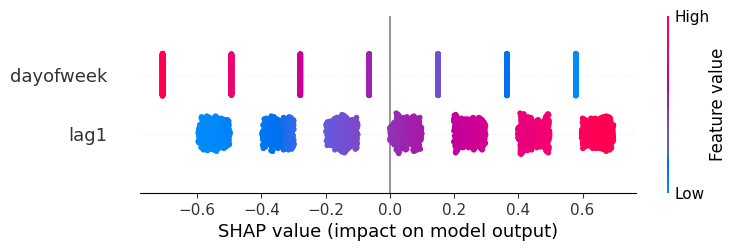

In [15]:
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(fcst.models_['lr'].predict, X100)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

## predictions

In [20]:
save_feats = SaveFeatures()
preds = fcst.predict(h = 1, before_predict_callback = save_feats)
preds.head()

,unique_id,ds,lr
0,id_0,2000-08-10,3.468643
1,id_1,2000-04-07,3.016877
2,id_2,2000-06-16,2.815249
3,id_3,2000-08-30,4.048894
4,id_4,2001-01-08,3.524532


In [21]:
features = save_feats.get_features()
features

,lag1,dayofweek
0,4.343744,3
1,3.150799,4
2,2.137412,4
3,6.182456,2
4,1.391698,0
5,1.059175,5
6,1.076548,5
7,4.196815,1
8,0.162962,1
9,2.061590,0


In [22]:
shap_values_predictions = explainer(features)

In [24]:
round(preds.loc[4, 'lr'], 3)

3.525

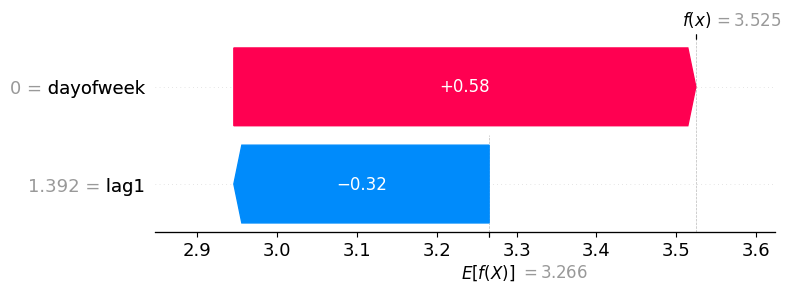

In [26]:
shap.plots.waterfall(shap_values_predictions[4])